# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [ ]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchsummary import summary
from sklearn.manifold import TSNE
from datetime import datetime

## Device

Set device to work with (GPU or CPU)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
cifar10_mean = np.array([0.49421428, 0.48513139, 0.45040909])
cifar10_std = np.array([0.24665252, 0.24289226, 0.26159238])

# Define the transform for the training set
transform_train = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  # Normalize the training set using cifar10_mean and cifar10_std
  transforms.Normalize(cifar10_mean, cifar10_std)
])

# Define the transform for the test set
transform_test = transforms.Compose([
  transforms.ToTensor(),
  # Normalize the test set using cifar10_mean and cifar10_std
  transforms.Normalize(cifar10_mean, cifar10_std)
])

# Define the unnormalize transform
unnormalize_transform = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ],
                         std = 1/cifar10_std),
    transforms.Normalize(mean = -cifar10_mean,
                         std = [ 1., 1., 1. ]),
])

In [ ]:
# Load the CIFAR10 dataset
cifar10_dataset = datasets.CIFAR10(root='dataset', train=True, download=True, transform=transform_train)

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(cifar10_dataset, [45000, 5000])

# Define the test dataset
test_dataset = datasets.CIFAR10(root='dataset', train=False, download=True, transform=transform_test)

# Define the dataloaders for train, validation, and test sets
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 55.6MB/s]


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

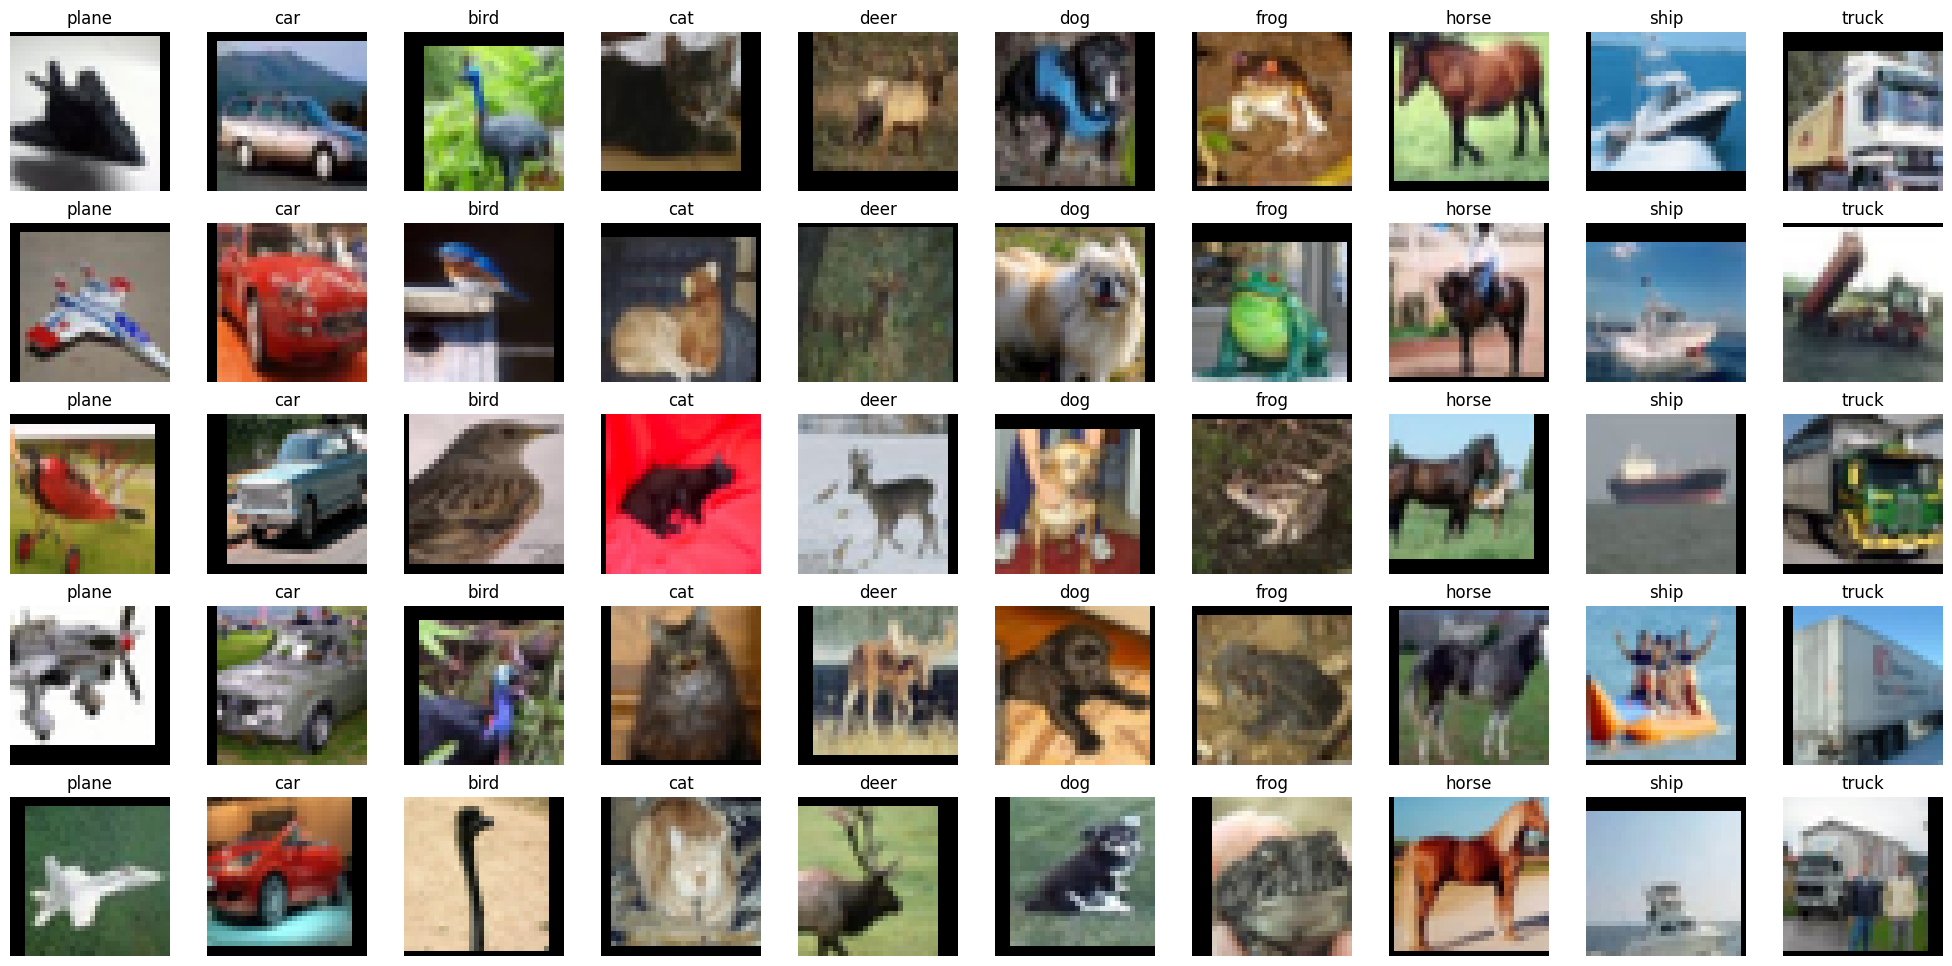

In [ ]:
num_images_to_display = 5
fig, axs = plt.subplots(num_images_to_display, len(classes), figsize=(25, 12))

# Create a dictionary to store images for each class
class_images = {i: [] for i in range(len(classes))}

# Iterate through the dataset to collect images
for img, label in cifar10_dataset:
    if all(len(class_images[i]) >= num_images_to_display for i in range(len(classes))):
        break
    if len(class_images[label]) < num_images_to_display:
        class_images[label].append(img)

# Display the images
for i in range(num_images_to_display):
    for j in range(len(classes)):
        img = class_images[j][i]
        img = unnormalize_transform(img)
        axs[i, j].imshow(img.permute(1, 2, 0))
        axs[i, j].set_title(classes[j])
        axs[i, j].axis('off')

plt.show()

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model)t have more than 10K parameters

**⚠️ Your model can not have more than 10K parameters ⚠️**

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

In [ ]:
# Sample network (Corrected to be under 10K parameters)
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # N > 10, here N will be 384
        self.feature_space = nn.Sequential(
            # Input: 3x32x32
            nn.Conv2d(3, 8, kernel_size=3, padding=1), # (3*3*3 + 1)*8 = 224 params
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 8x16x16

            nn.Conv2d(8, 16, kernel_size=3, padding=1), # (3*3*8 + 1)*16 = 1168 params
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 16x8x8

            nn.Conv2d(16, 24, kernel_size=3, padding=1), # (3*3*16 + 1)*24 = 3480 params
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 24x4x4

            nn.Flatten() # Output: 24*4*4 = 384
        )
        self.classifier = nn.Sequential(
            nn.Linear(24 * 4 * 4, 10) # (384 + 1)*10 = 3850 params
        )
        # Total params = 224 + 1168 + 3480 + 3850 = 8722

    def forward(self, x):
        features = self.feature_space(x)
        output = self.classifier(features)
        return output

In [ ]:
# ResNet18 implementation

class ResNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    assert stride == 1 or stride == 2

    super(ResNetBlock, self).__init__()

    self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    else:
      self.shortcut = nn.Identity()

  def forward(self, x):
    # ! Pay more attention to the shortcut connection
    return F.relu(self.block(x) + self.shortcut(x))


class ResNet18(nn.Module):
  def __init__(self, img_channels=3, num_classes=10):
    super(ResNet18, self).__init__()
    self.in_channels = 64
    self.feature_space = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            self._make_layer(ResNetBlock, 64, 2, stride=1),
            self._make_layer(ResNetBlock, 128, 2, stride=2),
            self._make_layer(ResNetBlock, 256, 2, stride=2),
            self._make_layer(ResNetBlock, 512, 2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    self.classifier = nn.Linear(512, num_classes)

  def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

  def forward(self, x):
    x = self.feature_space(x)
    x = self.classifier(x)
    return x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
model = SimpleNet().to(device)
# Print the model summary
summary(model, (3, 32, 32))

# Print model parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
              ReLU-2            [-1, 8, 32, 32]               0
         MaxPool2d-3            [-1, 8, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           1,168
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7             [-1, 24, 8, 8]           3,480
              ReLU-8             [-1, 24, 8, 8]               0
         MaxPool2d-9             [-1, 24, 4, 4]               0
          Flatten-10                  [-1, 384]               0
           Linear-11                   [-1, 10]           3,850
Total params: 8,722
Trainable params: 8,722
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)
Suggestions:
- **Criterion**: `Cross Entropy Loss`
- **Optimizer**: `Adam` or `SGD`
- **Learning Rate**: 0.001 or 0.01
- **Scheduler**: `StepLR`

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

### Train loop

Write a function to train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=35, device='cuda'):
  """
  Train a PyTorch model and evaluate it on validation data

  Parameters:
  -----------
  model : The neural network model to train
  train_loader : DataLoader for the training dataset
  val_loader : DataLoader for the validation dataset
  criterion : Loss function
  optimizer : Optimizer for model parameters
  scheduler : Learning rate scheduler
  num_epochs : Number of epochs to train
  device : Device to use for training ('cuda' or 'cpu')

  Returns:
  --------
    model : The trained model
  dict
    Dictionary containing training history:
    - 'train_loss': list of training losses for each epoch
    - 'val_loss': list of validation losses for each epoch
    - 'train_acc': list of training accuracies for each epoch
    - 'val_acc': list of validation accuracies for each epoch
  """
  train_loss_arr, val_loss_arr = [], []
  train_acc_arr, val_acc_arr = [], []

  for epoch in range(num_epochs):
    train_loss, val_loss = .0, .0
    train_acc, val_acc = .0, .0

    # Training phase
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * images.size(0)
      _, predicted = torch.max(outputs.data, 1)
      train_acc += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc /= len(train_loader.dataset)
    val_acc /= len(val_loader.dataset)

    # Save metrics for plotting
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    train_acc_arr.append(train_acc)
    val_acc_arr.append(val_acc)


    # Print progress
    if (epoch + 1) % 5 == 0:
      print(f"[Epoch {epoch+1}]\t"
            f"[{datetime.now().strftime('%H:%M:%S')}]\t"
            f"Train Loss: {train_loss:.4f}\t"
            f"Train Accuracy: {train_acc:.2f}\t"
            f"Validation Loss: {val_loss:.4f}\t\t"
            f"Validation Accuracy: {val_acc:.2f}")

    scheduler.step()

  return model, {
    'train_loss': train_loss_arr,
    'val_loss': val_loss_arr,
    'train_acc': train_acc_arr,
    'val_acc': val_acc_arr
    }

### Train your model

- [ ] Train your model for 30~50 epochs
- [ ] Save your model after training with the name `simple_cnn.pth`


In [ ]:
num_epochs=40
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, device=device)

[Epoch 5]	[19:01:30]	Train Loss: 1.3343	Train Accuracy: 0.52	Validation Loss: 1.3102		Validation Accuracy: 0.54
[Epoch 10]	[19:04:20]	Train Loss: 1.1807	Train Accuracy: 0.58	Validation Loss: 1.1762		Validation Accuracy: 0.58
[Epoch 15]	[19:07:06]	Train Loss: 1.1233	Train Accuracy: 0.61	Validation Loss: 1.1415		Validation Accuracy: 0.60
[Epoch 20]	[19:09:57]	Train Loss: 1.1163	Train Accuracy: 0.61	Validation Loss: 1.1183		Validation Accuracy: 0.60
[Epoch 25]	[19:12:41]	Train Loss: 1.1099	Train Accuracy: 0.61	Validation Loss: 1.1191		Validation Accuracy: 0.61
[Epoch 30]	[19:15:27]	Train Loss: 1.1084	Train Accuracy: 0.61	Validation Loss: 1.1306		Validation Accuracy: 0.60
[Epoch 35]	[19:18:09]	Train Loss: 1.1080	Train Accuracy: 0.61	Validation Loss: 1.1218		Validation Accuracy: 0.60
[Epoch 40]	[19:20:57]	Train Loss: 1.1026	Train Accuracy: 0.62	Validation Loss: 1.1404		Validation Accuracy: 0.60


In [16]:
torch.save(model.state_dict(), 'simple_cnn.pth')

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

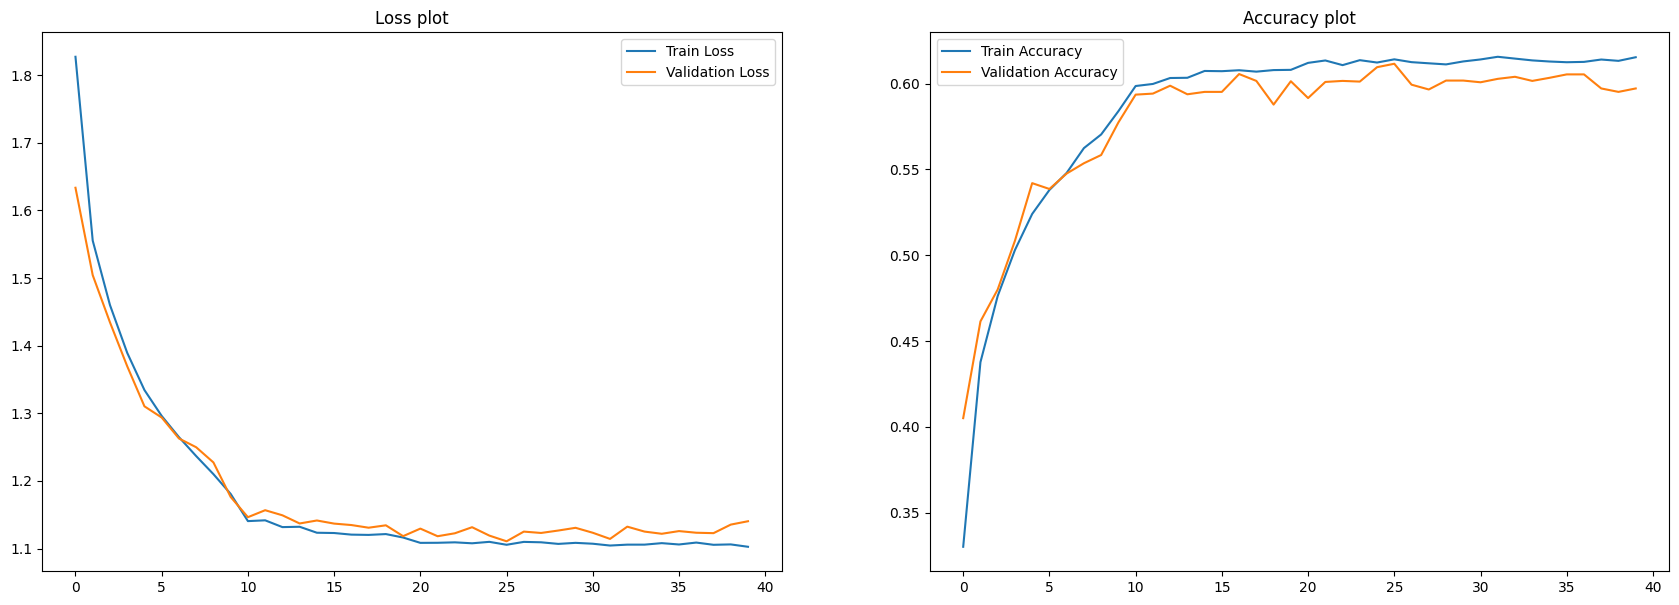

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(21, 7))

axs[0].set_title("Loss plot")
axs[0].plot(history['train_loss'])
axs[0].plot(history['val_loss'])
axs[0].legend(["Train Loss", "Validation Loss"]);

axs[1].set_title("Accuracy plot")
axs[1].plot(history['train_acc'])
axs[1].plot(history['val_acc'])
axs[1].legend(["Train Accuracy", "Validation Accuracy"]);

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy under 80% on the test set

In [ ]:
model = ResNet18().to(device)

# Print the model summary
summary(model, (3, 32, 32))

# Print model parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

# Re-define optimizer and scheduler for the new model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the ResNet18 model
num_epochs=30
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
          Identity-9           [-1, 64, 32, 32]               0
      ResNetBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(21, 7))

axs[0].set_title("Loss plot")
axs[0].plot(history['train_loss'])
axs[0].plot(history['val_loss'])
axs[0].legend(["Train Loss", "Validation Loss"]);

axs[1].set_title("Accuracy plot")
axs[1].plot(history['train_acc'])
axs[1].plot(history['val_acc'])
axs[1].legend(["Train Accuracy", "Validation Accuracy"]);

Now that you have trained your model, it's time to train the ResNet model.

In [ ]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

0.9365


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

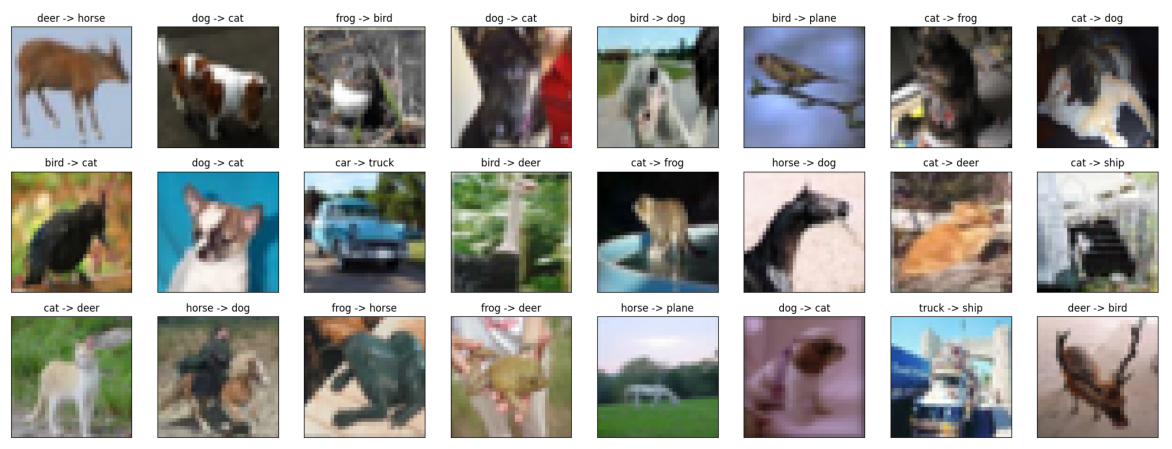

In [ ]:
num_rows, num_cols = 3, 8
num_wrong_pred_to_show = num_rows * num_cols

wrong_labeled_imgs = []
model.eval()
# Get wrong predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        wrong_mask = predicted != labels

        for i in range(images.size(0)):
            if wrong_mask[i]:
                wrong_labeled_imgs.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))
        if len(wrong_labeled_imgs) >= num_wrong_pred_to_show:
            break

# Display wrong predictions
fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 12))
for i in range(num_wrong_pred_to_show):
    img, pred, true = wrong_labeled_imgs[i]
    img = unnormalize_transform(img)
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(img.permute(1, 2, 0))
    axs[row, col].set_title(f"Pred: {classes[pred]}\nTrue: {classes[true]}")
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()